In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow.keras import models

from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception, EfficientNetB2
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


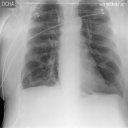

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

os.listdir('/content/drive/MyDrive/Datasets/SIIM_Severity_Updated')

Negative=os.listdir('/content/drive/MyDrive/Datasets/SIIM_Severity_Updated/negative')
im =Image.open('/content/drive/MyDrive/Datasets/SIIM_Severity_Dataset/train/negative/000c3a3f293f.jpg').resize((128,128))
im
Atypical=os.listdir('/content/drive/MyDrive/Datasets/SIIM_Severity_Updated/atypical')
Indeterminate=os.listdir('/content/drive/MyDrive/Datasets/SIIM_Severity_Updated/indeterminate')
Typical=os.listdir('/content/drive/MyDrive/Datasets/SIIM_Severity_Updated/typical')

#Training_all = np.concatenate([Negative,Atypical,Indeterminate,Typical])
#train_path = '/content/drive/MyDrive/Datasets/SIIM_Severity_Dataset/train'
#valid_path = '/content/drive/MyDrive/Datasets/SIIM_Severity_Dataset/test'
im

In [ ]:
target_w=np.full(len(Negative),0)
target_x=np.full(len(Atypical),1)
target_y=np.full(len(Indeterminate),2)
target_z=np.full(len(Typical),3)

data_target=np.concatenate([target_w,target_x,target_y,target_z])
len(data_target)==len(target_w)+len(target_x)+len(target_y)+len(target_z)

len(data_target)

11179

In [ ]:
Training_data= np.load('/content/drive/MyDrive/Datasets/NUMPY_224/Training_Data_X.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
len(Training_data)

11179

In [ ]:
X = np.squeeze(Training_data)

In [ ]:
# normalize data
X = X.astype('float16')
X /= 255

In [ ]:
len(X)

11179

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X,data_target, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


In [ ]:
print(X_train.shape, X_test.shape,X_valid.shape, y_train.shape,y_valid.shape, y_test.shape)

(8943, 224, 224, 3) (1118, 224, 224, 3) (1118, 224, 224, 3) (8943,) (1118,) (1118,)


In [ ]:
Training_data = X =[]

In [ ]:
print(y_test[1:100])

[1 3 3 2 0 2 1 1 3 2 2 1 3 0 0 3 2 1 2 0 3 0 2 0 2 3 2 0 2 3 2 1 1 3 3 1 2
 3 1 0 3 1 3 0 2 2 2 1 0 2 2 0 2 3 2 1 1 1 1 1 2 0 3 1 2 1 2 0 0 3 1 0 1 2
 1 0 2 1 0 1 1 1 1 2 3 2 3 1 2 2 1 3 1 0 3 1 2 0 2]


In [ ]:

#from d2l import tensorflow as d2l

class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 =  tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)


In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU
from keras.layers import LeakyReLU
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
hidden_unit = 32
kernel_size = 3
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())

model.add(ResnetBlock(64, 2, first_block=True))
model.add(ResnetBlock(64, 2, first_block=True))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(128, 2))
model.add(ResnetBlock(128, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(256, 2))
model.add(ResnetBlock(256, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(1,2), strides=(1,2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256 , activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 resnet_block_1 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 batch_normalization_14 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                     

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
file_path = os.path.join('/content/drive/MyDrive/Models', 'Fourclass(SIIM)_Residual-Bi-GRU_without_KFold(Curated_Dataset)', 'FourCLass.h5')
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
ckp = ModelCheckpoint(filepath= file_path,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min', save_weights_only=True)

In [ ]:
fit_history = model.fit(X_train,
                        y_train,
                        batch_size = 8,
                        #shuffle = True,
                        epochs = 50,
                        #initial_epoch=10,
                        validation_data = (X_valid,y_valid),
                        callbacks=[rlr,ckp])
        

Epoch 1/50
1118/1118 [==============================] - ETA: 0s - loss: 1.4794 - accuracy: 0.3287
Epoch 00001: val_loss improved from inf to 1.36445, saving model to /content/drive/MyDrive/Models/Fourclass(SIIM)_Residual-Bi-GRU_without_KFold(Curated_Dataset)/FourCLass.h5
1118/1118 [==============================] - 167s 149ms/step - loss: 1.4794 - accuracy: 0.3287 - val_loss: 1.3644 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 2/50
1118/1118 [==============================] - ETA: 0s - loss: 1.4064 - accuracy: 0.3435
Epoch 00002: val_loss improved from 1.36445 to 1.30640, saving model to /content/drive/MyDrive/Models/Fourclass(SIIM)_Residual-Bi-GRU_without_KFold(Curated_Dataset)/FourCLass.h5
1118/1118 [==============================] - 167s 150ms/step - loss: 1.4064 - accuracy: 0.3435 - val_loss: 1.3064 - val_accuracy: 0.4186 - lr: 0.0010
Epoch 3/50
1118/1118 [==============================] - ETA: 0s - loss: 1.3598 - accuracy: 0.3725
Epoch 00003: val_loss improved from 1.30640 to 1.26747

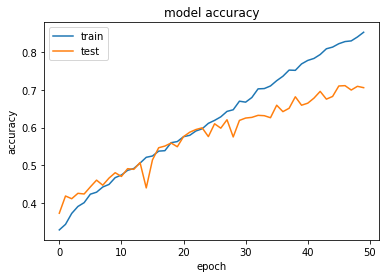

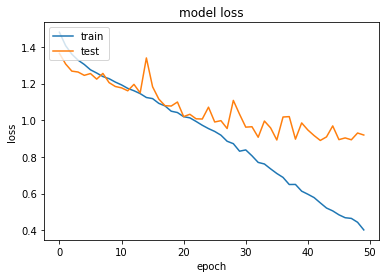

In [ ]:
# summarize history for accuracy
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Evaluation on Testing Data**

In [ ]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score

#actual =  valid_data.labels
preds = np.argmax(model.predict(X_test), axis=1)
cfmx = confusion_matrix(y_test, preds)
acc = accuracy_score(y_test,preds)
print ('Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Test Accuracy: 0.8067978533094812
Confusion matrix: tf.Tensor(
[[199  17  21  24]
 [  5 292   4   6]
 [ 24  13 228  28]
 [ 36   6  32 183]], shape=(4, 4), dtype=int32)


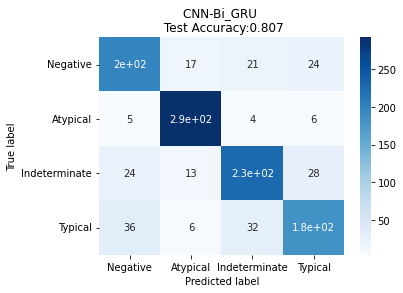

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# Creates a confusion matrix
cm = confusion_matrix(y_test, preds) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Atypical', 'Indeterminate','Typical'], 
                     columns = ['Negative','Atypical', 'Indeterminate','Typical'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('CNN-Bi_GRU \n Test Accuracy:{0:.3f}'.format(accuracy_score(y_test, preds)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       261
           1       0.89      0.95      0.92       307
           2       0.80      0.78      0.79       293
           3       0.76      0.71      0.73       257

    accuracy                           0.81      1118
   macro avg       0.80      0.80      0.80      1118
weighted avg       0.80      0.81      0.81      1118



In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(y_test, preds, average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y_test, preds, average='weighted')
print('Recall: %.3f' % recall)
score = f1_score(y_test, preds, average='weighted')
print('F-Measure: %.3f' % score)

Precision: 0.805
Recall: 0.807
F-Measure: 0.805
